In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission-road-density/Submission_template_UHI2025-v2.csv
/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv


In [16]:
pip install overpy

Note: you may need to restart the kernel to use updated packages.


Number of road ways fetched: 26021


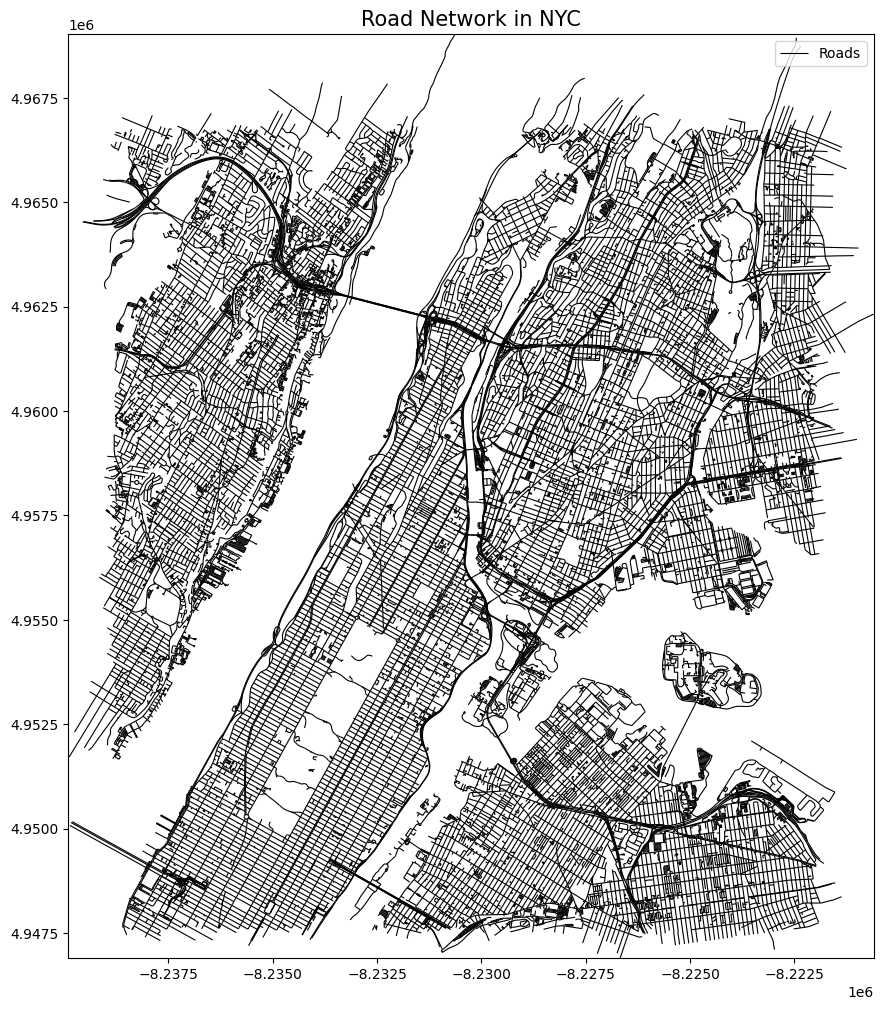

In [17]:
import overpy
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point

# Initialize Overpass API
api = overpy.Overpass()

# Define bounding box (Lat, Lon)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

# Overpass query for roads
overpass_query = f"""
[out:json];
(
  way["highway"~"motorway|trunk|primary|secondary|tertiary|residential|service|unclassified|living_street|road"]({lower_left[0]},{lower_left[1]},{upper_right[0]},{upper_right[1]});
);
out body;
(._;>;);
out skel qt;
"""

try:
    # Fetch data from Overpass API
    result = api.query(overpass_query)
    print(f"Number of road ways fetched: {len(result.ways)}")

    # Convert ways into LineStrings
    geometries, names = [], []
    for way in result.ways:
        nodes = [(float(node.lon), float(node.lat)) for node in way.nodes]
        if len(nodes) >= 2:
            geometries.append(LineString(nodes))
            names.append(way.tags.get('name', 'Unnamed'))

    # Create GeoDataFrame for roads
    if geometries:
        gdf_roads = gpd.GeoDataFrame({'name': names, 'geometry': geometries}, crs="EPSG:4326")

        # Reproject to metric CRS (EPSG:3395) for length calculation
        gdf_roads = gdf_roads.to_crs(epsg=3395)
        gdf_roads['length_m'] = gdf_roads.geometry.length  # Road length in meters

        # Plot the roads
        fig, ax = plt.subplots(figsize=(12, 12))
        gdf_roads.plot(ax=ax, color="black", linewidth=0.8, label="Roads")
        ax.set_xlim(gdf_roads.total_bounds[0], gdf_roads.total_bounds[2])
        ax.set_ylim(gdf_roads.total_bounds[1], gdf_roads.total_bounds[3])
        ax.set_title("Road Network in NYC", fontsize=15)
        ax.legend()
        ax.axis('on')
        plt.show()

    else:
        print("No roads found to plot.")
except overpy.exception.OverpassTooManyRequests:
    print("Too many requests to Overpass API. Please wait and try again.")
except Exception as e:
    print(f"Error: {str(e)}")

In [18]:
train_df = pd.read_csv("/kaggle/input/uncorrupted-training-data/Training_data_uhi_index_2025-02-18.csv")

In [19]:
train_df

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245


In [20]:
# Convert train_df to GeoDataFrame
gdf_train = gpd.GeoDataFrame(
    train_df,
    geometry=[Point(lon, lat) for lon, lat in zip(train_df['Longitude'], train_df['Latitude'])],
    crs="EPSG:4326"
).to_crs(epsg=3395)

# Define buffer radius (in meters)
buffer_radius = 200  

# Create buffer around each point
gdf_train['buffer'] = gdf_train.geometry.buffer(buffer_radius)

# Calculate total road length within the buffer
def road_length_in_buffer(buffer_geom):
    return gdf_roads[gdf_roads.intersects(buffer_geom)]['length_m'].sum()

# Apply the function to each buffer
gdf_train['road_density'] = gdf_train['buffer'].apply(road_length_in_buffer)

# Add the road_density feature back to the original train_df
train_df['road_density'] = gdf_train['road_density']

# Check results
print(train_df[['Latitude', 'Longitude', 'road_density']].head())

    Latitude  Longitude  road_density
0  40.813107 -73.909167   4095.234026
1  40.813045 -73.909187   4095.234026
2  40.812978 -73.909215   4095.234026
3  40.812908 -73.909242   3669.525181
4  40.812845 -73.909257   3590.804662


In [21]:
train_df['road_density'].describe()

count    11229.000000
mean      5088.283918
std       2377.195964
min          0.000000
25%       3572.519292
50%       4704.786218
75%       6247.008180
max      15710.598901
Name: road_density, dtype: float64

In [22]:
train_df.to_csv('train_df_with_road_density.csv', index=False)

In [23]:
valid_df = pd.read_csv("/kaggle/input/submission-road-density/Submission_template_UHI2025-v2.csv")

In [24]:
valid_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN
...,...,...,...
1035,-73.919388,40.813803,NaN
1036,-73.931033,40.833178,NaN
1037,-73.934647,40.854542,NaN
1038,-73.917223,40.815413,NaN


In [25]:
# Convert valid_df to GeoDataFrame
gdf_valid = gpd.GeoDataFrame(
    valid_df,
    geometry=[Point(lon, lat) for lon, lat in zip(valid_df['Longitude'], valid_df['Latitude'])],
    crs="EPSG:4326"
).to_crs(epsg=3395)

# Define buffer radius (in meters)
buffer_radius = 200  

# Create buffer around each point
gdf_valid['buffer'] = gdf_valid.geometry.buffer(buffer_radius)

# Calculate total road length within the buffer
def road_length_in_buffer(buffer_geom):
    return gdf_roads[gdf_roads.intersects(buffer_geom)]['length_m'].sum()

gdf_valid['road_density'] = gdf_valid['buffer'].apply(road_length_in_buffer)

# Add the road_density feature back to the original DataFrame
valid_df['road_density'] = gdf_valid['road_density']

# Check results
print(valid_df[['Latitude', 'Longitude', 'road_density']].head())

    Latitude  Longitude  road_density
0  40.788763 -73.971665   4071.631881
1  40.788875 -73.971928   4118.625328
2  40.789080 -73.967080   3555.795610
3  40.789082 -73.972550   4306.327836
4  40.787953 -73.969697   4071.631881


In [26]:
valid_df['road_density'].describe()

count     1040.000000
mean      5062.470980
std       2301.659252
min          0.000000
25%       3626.342152
50%       4652.137480
75%       6164.933137
max      15710.598901
Name: road_density, dtype: float64

In [28]:
valid_df.to_csv('valid_df_with_road_density.csv', index=False)